# Tarea 4: Personalización

<a href="https://github.com/carlosperez1997/proyecto_easyMoney/blob/main/README.md" target="_blank">Volver a Página Principal</a>

El objetivo de la tarea 4 es segmentar los 10.000 emails de la recomendación de productos (tarea 3) en 4 o 5 creatividades diferentes en función del perfil de los  clientes, para comunicarnos con ellos de una forma más efectiva.

Para alcanzar este objetivo aplicaremos tareas de aprendizaje no supervisado de Machine Learning. En concreto, aplicaremos el algoritmo de K-Means para particionar un conjunto de 10.000 clientes en 4 o 5 clusters. Cumpliendo las siguientes condiciones:

1) Cada cliente será asignado a un solo cluster.

2) Todos los clusters tendrán al menos un cliente asignado.

3) Los clientes pertenecerán a un solo cluster, no habrán solapes.

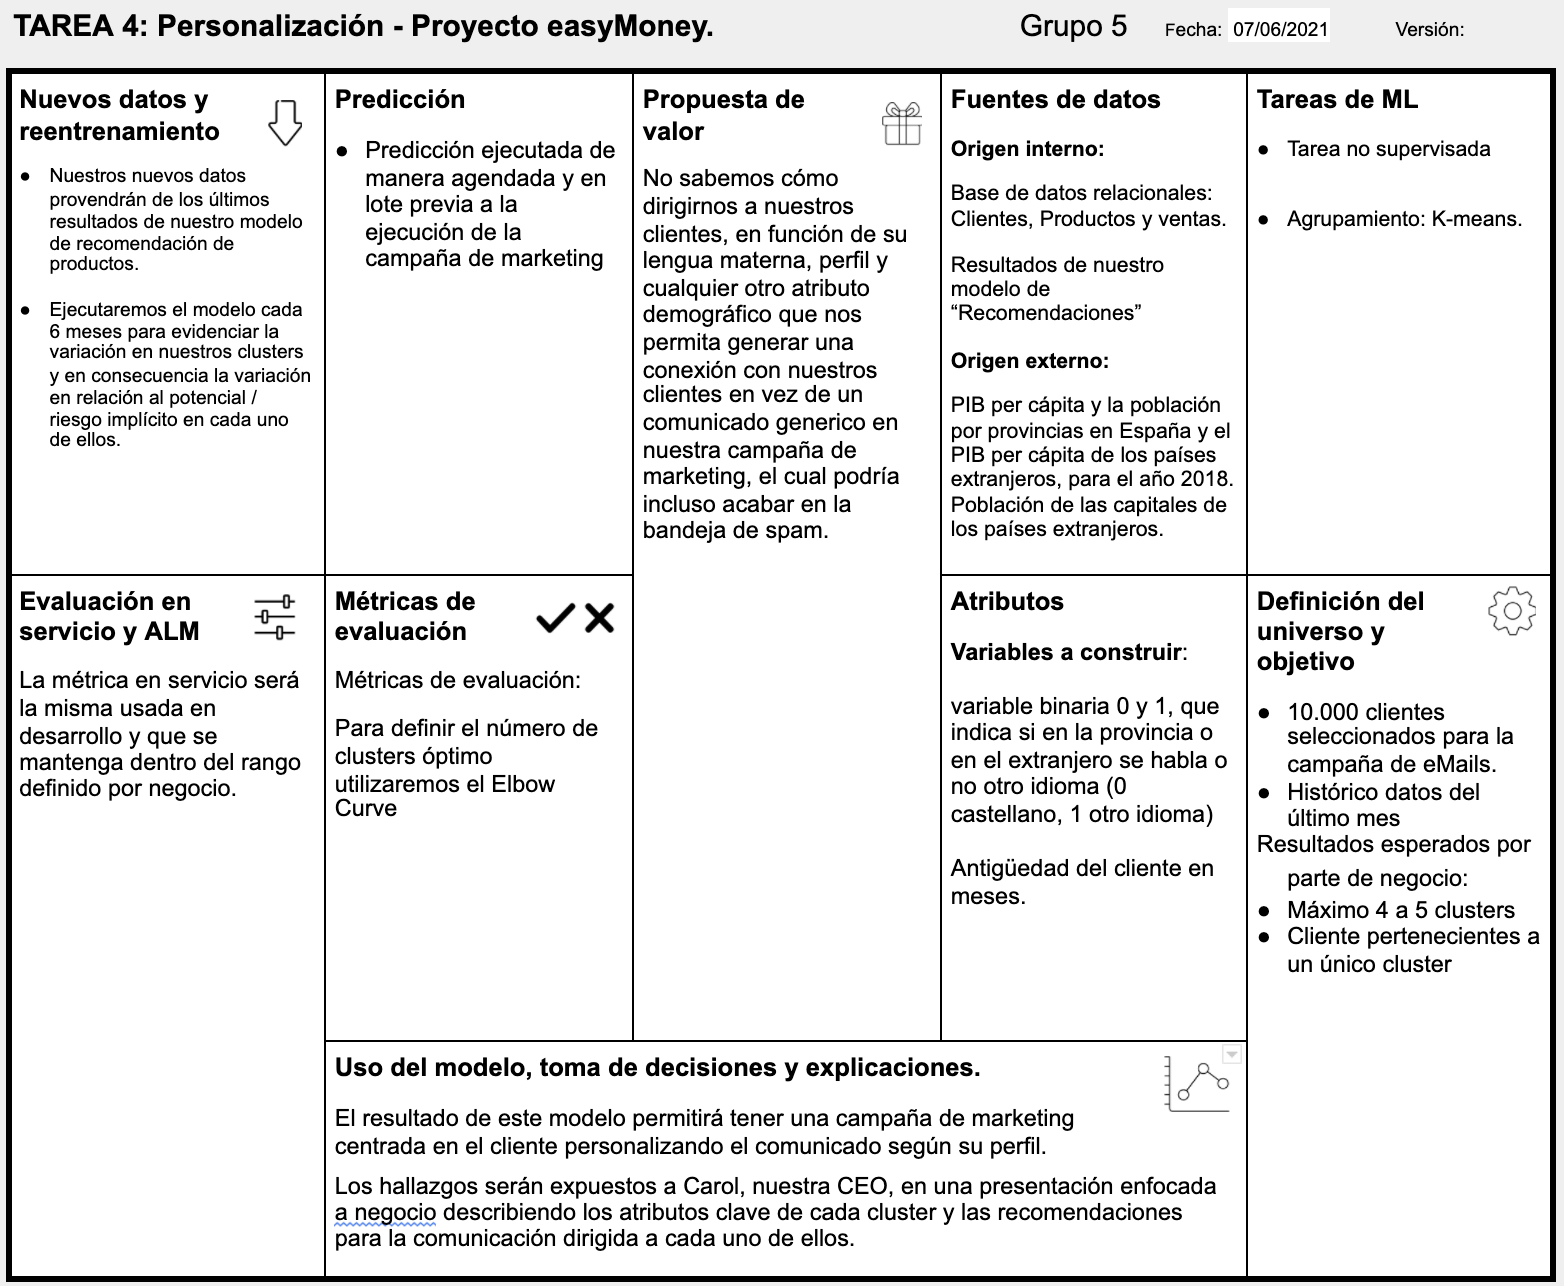

In [1]:
from IPython.display import Image
Image('./ML_canvas_4.png') 

## Tabla de contenido <a class="anchor" id="0"></a>

1. [Importación de librerías](#origin) <br> 
2. [Importación de los datasets](#01) <br> 
3. [Construcción del dataset ](#02) <br>
3. [Incorporación, generación y transformación de atributos](#03) <br>
3. [Limpieza de atributos](#04) <br>
3. [Tratamiento de nulos](#05) <br>
3. [Selección de los datos](#06) <br>
3. [Modelling](#07) <br>
3. [Elbow curve](#08) <br>
3. [Descripción de los clusters](#09) <br>
10. [Conclusiones](#10) <br> 





## Importación de librerías <a class="anchor" id="origin"></a>
[Tabla de Contenidos](#0)

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os

import warnings
warnings.filterwarnings("ignore")

# time calculation to track some processes
import time

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

!pip install xlrd==1.2.0

import xlrd

import pickle

     |████████████████████████████████| 103 kB 1.3 MB/s 


## Importación de los datasets <a class="anchor" id="01"></a>
[Tabla de Contenidos](#0)

In [2]:
PATH_DATA = "../input/easymoneygrupo5/"

In [3]:
comercial = pd.read_csv(PATH_DATA+'commercial_activity_df.csv', encoding='utf-8')
comercial.drop(columns=['Unnamed: 0'], inplace=True)

productos = pd.read_csv(PATH_DATA+'products_df.csv', encoding='utf-8')
productos.drop(columns=['Unnamed: 0'], inplace=True)

socio = pd.read_csv(PATH_DATA+'sociodemographic_df.csv', encoding='utf-8')
socio.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
# para aligerar el tamaño de los ficheros se cambia el tipo de datos a int8
for i in productos.columns:
        if (productos[i].dtype=="int64" and [i]!=["pk_cid"]):
            productos[i]=productos[i].astype("int8")
        else:            
            productos[i]=productos[i]
            
comercial["active_customer"]=comercial["active_customer"].astype('int8')
socio["age"]=socio["age"].astype('int8')

In [5]:
recomendaciones_finales = pd.read_csv(PATH_DATA+'recomendaciones_finales.csv', encoding='utf-8')
recomendaciones_finales.drop(columns=['Unnamed: 0'], inplace=True)

### Incorporación de datos de fuentes externas
Añadimos el dataset pibpc que tiene datos sobre el PIB per cápita y la población por provincias en España (fuente INE España) y el PIB per cápita de los países extranjeros (fuente: World Bank), para el año 2018. Población de las capitales de los países extranjeros (fuente: World Bank).

Además, tenemos una variable binaria 0 y 1 que indica si en la provincia o en el extranjero se habla o no otro idioma (0 castellano, 1 otro idioma).

In [6]:
pibpc = pd.read_excel(PATH_DATA+'pibpc.xls', sheet_name = 'pibpc')

In [7]:
pibpc.head()

,residencia_id,pibpc,idiomas,poblacion
0,1,36404.0,1,331549.0
1,2,21153.0,0,388167.0
2,3,19757.0,0,1858683.0
3,4,19919.0,0,716820.0
4,5,20423.0,0,157640.0


## Construcción del dataset <a class="anchor" id="02"></a>
[Tabla de Contenidos](#0)

El dataset recomendacion_finales es el resultado de la Tarea 3 Recomendación. Contiene el pk_cid de los 10.000 clientes a los cuales se les enviarán un email, la recomendación, precio del producto a recomendar y probabilidad de la compra. Partiremos de este dataset para construir el dataset de la segmentación para la personalización.

In [8]:
recomendaciones_finales.head()

,pk_cid,recomendacion,precio,prob
0,45483,debit_card,60,0.270047
1,46823,debit_card,60,0.757964
2,148406,debit_card,60,0.759261
3,151516,debit_card,60,0.309882
4,177092,debit_card,60,0.762794


In [9]:
personalizacion=recomendaciones_finales.copy(deep=True)

Añadiremos el resto de ficheros al dataset de personalización escogiendo solo los datos de la partición correspondiente al último mes disponible

In [10]:
comercial=comercial[comercial['pk_partition']=='2019-05-28']
comercial.drop(columns=["pk_partition"], inplace=True)
socio=socio[socio['pk_partition']=='2019-05-28']
socio.drop(columns=["pk_partition"], inplace=True)

In [11]:
personalizacion=pd.merge(personalizacion, socio, on=['pk_cid'], how='left') 

In [12]:
personalizacion=pd.merge(personalizacion, comercial, on=['pk_cid'], how='left') 

In [13]:
# corrigiendo la fecha de entry_date mal codificada
personalizacion.loc[personalizacion['entry_date'] == '2015-02-29', 'entry_date'] = '2015-02-28'
personalizacion.loc[personalizacion['entry_date'] == '2019-02-29', 'entry_date'] = '2019-02-28'
personalizacion["fecha_entrada"] = pd.to_datetime(personalizacion["entry_date"], format = "%Y-%m-%d")

In [14]:
personalizacion.head()

,pk_cid,recomendacion,precio,prob,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,fecha_entrada
0,45483,debit_card,60,0.270047,ES,28.0,H,59,N,77361.60,2015-10-05,KFA,1,01 - TOP,2015-10-05
1,46823,debit_card,60,0.757964,ES,28.0,H,74,N,373566.06,2017-10-07,KAT,1,02 - PARTICULARES,2017-10-07
2,148406,debit_card,60,0.759261,ES,9.0,V,47,N,114469.35,2018-02-04,KHK,1,01 - TOP,2018-02-04
3,151516,debit_card,60,0.309882,ES,28.0,V,54,N,153521.76,2017-10-06,KAT,1,01 - TOP,2017-10-06
4,177092,debit_card,60,0.762794,ES,8.0,V,41,N,79753.89,2016-01-07,KAT,1,02 - PARTICULARES,2016-01-07


### Incorporación, generación y transformación de atributos <a class="anchor" id="03"></a>
[Tabla de Contenido](#0)

Incluimos el atributo PIB per cápita y población por provincia y por países.
También incluimos si en el país o provincia se habla otro idioma.
Para ello, construimos una variable 'residencia_id' que para España toma region_code y para fuera de España coge country_id. Así, tenemos la población, PIB per cápita y el idioma referidos a España a nivel de provincia y para el resto de países a nivel de capitales de países.

In [15]:
personalizacion['residencia_id']=personalizacion['country_id']
personalizacion.replace({'residencia_id' : 'ES'}, np.nan, inplace=True)
nan_filter = pd.Series(personalizacion['residencia_id'][personalizacion['country_id'] =='ES'].isnull())
nan_filter = nan_filter[nan_filter].index.values
nan_filter= pd.Series(nan_filter) 
personalizacion.loc[nan_filter, 'residencia_id'] = personalizacion.loc[nan_filter, 'residencia_id'].fillna(personalizacion['region_code'])

In [16]:
personalizacion=pd.merge(personalizacion, pibpc, on=['residencia_id'], how='left')

In [17]:
personalizacion.head()

,pk_cid,recomendacion,precio,prob,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,fecha_entrada,residencia_id,pibpc,idiomas,poblacion
0,45483,debit_card,60,0.270047,ES,28.0,H,59,N,77361.60,2015-10-05,KFA,1,01 - TOP,2015-10-05,28.0,35091.0,0,6663394.0
1,46823,debit_card,60,0.757964,ES,28.0,H,74,N,373566.06,2017-10-07,KAT,1,02 - PARTICULARES,2017-10-07,28.0,35091.0,0,6663394.0
2,148406,debit_card,60,0.759261,ES,9.0,V,47,N,114469.35,2018-02-04,KHK,1,01 - TOP,2018-02-04,9.0,29571.0,0,356958.0
3,151516,debit_card,60,0.309882,ES,28.0,V,54,N,153521.76,2017-10-06,KAT,1,01 - TOP,2017-10-06,28.0,35091.0,0,6663394.0
4,177092,debit_card,60,0.762794,ES,8.0,V,41,N,79753.89,2016-01-07,KAT,1,02 - PARTICULARES,2016-01-07,8.0,30947.0,1,5664579.0


Del dataset de productos nos gustaria tener la media de productos que tiene mensualmente cada uno de los clientes. 

In [18]:
productos["payroll"].fillna(0, inplace=True)
productos["pension_plan"].fillna(0, inplace=True)
productos['pension_plan']=productos['pension_plan'].astype(int)
productos['payroll']=productos['pension_plan'].astype(int)

In [19]:
productos.tail()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5962923,1550586,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [20]:
productos['total'] = productos.iloc[:,2:].sum(axis=1)

In [21]:
media_producto=productos[['pk_cid', 'total']]
media_productos=media_producto.groupby(['pk_cid']).mean()[['total']].reset_index()
media_productos

,pk_cid,total
0,15891,0.500000
1,16063,0.000000
2,16203,0.833333
3,16502,1.444444
4,17457,2.235294
...,...,...
456368,1553685,0.000000
456369,1553686,0.000000
456370,1553687,0.000000
456371,1553688,0.000000


In [22]:
# incorporamos la cantidad media mensual de productos que tienen los clientes
personalizacion=pd.merge(personalizacion, media_productos, on=['pk_cid'], how='left')

In [23]:
personalizacion.head()

,pk_cid,recomendacion,precio,prob,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,fecha_entrada,residencia_id,pibpc,idiomas,poblacion,total
0,45483,debit_card,60,0.270047,ES,28.0,H,59,N,77361.60,2015-10-05,KFA,1,01 - TOP,2015-10-05,28.0,35091.0,0,6663394.0,2.235294
1,46823,debit_card,60,0.757964,ES,28.0,H,74,N,373566.06,2017-10-07,KAT,1,02 - PARTICULARES,2017-10-07,28.0,35091.0,0,6663394.0,1.176471
2,148406,debit_card,60,0.759261,ES,9.0,V,47,N,114469.35,2018-02-04,KHK,1,01 - TOP,2018-02-04,9.0,29571.0,0,356958.0,2.187500
3,151516,debit_card,60,0.309882,ES,28.0,V,54,N,153521.76,2017-10-06,KAT,1,01 - TOP,2017-10-06,28.0,35091.0,0,6663394.0,2.000000
4,177092,debit_card,60,0.762794,ES,8.0,V,41,N,79753.89,2016-01-07,KAT,1,02 - PARTICULARES,2016-01-07,8.0,30947.0,1,5664579.0,1.058824


In [24]:
personalizacion.rename(columns={"total":"media_prod"}, inplace=True)

In [25]:
# calculamos la antiguedad del cliente en meses para incorporarla como nuevo atributo
personalizacion["ultimo_mes"]="2019-05-28"
personalizacion["ultimo_mes"] = pd.to_datetime(personalizacion["ultimo_mes"], format = "%Y-%m-%d")
personalizacion["antiguedad"]=(personalizacion["ultimo_mes"]-personalizacion["fecha_entrada"])/np.timedelta64(1,'M')

In [26]:
personalizacion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   pk_cid           10000 non-null  int64         
 1   recomendacion    10000 non-null  object        
 2   precio           10000 non-null  int64         
 3   prob             10000 non-null  float64       
 4   country_id       10000 non-null  object        
 5   region_code      9991 non-null   float64       
 6   gender           10000 non-null  object        
 7   age              10000 non-null  int8          
 8   deceased         10000 non-null  object        
 9   salary           6007 non-null   float64       
 10  entry_date       10000 non-null  object        
 11  entry_channel    9998 non-null   object        
 12  active_customer  10000 non-null  int8          
 13  segment          9998 non-null   object        
 14  fecha_entrada    10000 non-null  dateti

In [27]:
# Dummy del gender con varon==1 y mujer==0
personalizacion = pd.get_dummies(personalizacion, columns = ["gender"], drop_first = True)

### Limpieza de atributos <a class="anchor" id="04"></a>
[Tabla de Contenido](#0)

Borramos las columnas que son object, id que ya no necesitamos. También borramos las columnas que no aportarán información para una comunicación distinta entre un cluster y otra como, por ejemplo, entry_channel (al no tener información sobre estos canales de entrada de los clientes, no podemos saber si se distinguen entre un canal y otro)

In [28]:
# verificamos que no hay fallecidos en el dataset para poder eliminar esta columna
personalizacion['deceased'].value_counts()

N    10000
Name: deceased, dtype: int64

In [29]:
# se borra active_customer porque solo hay 7 clientes que no son activos en la plataforma en los últimos 3 meses
personalizacion['active_customer'].value_counts()

1    9993
0       7
Name: active_customer, dtype: int64

In [30]:
col_borrar=['recomendacion', 'precio', 'prob', 'country_id', 'region_code','deceased', 'entry_channel', 'residencia_id', 'entry_date', 'fecha_entrada', 'ultimo_mes', 'active_customer']
personalizacion.drop(col_borrar, axis=1, inplace=True)

PIBpc y Población nos pueden indicar el tamaño y caracteristica del lugar de residencia del cliente, observamos que entre PIBpc y población existe una alta correlación, por lo que nos quedaremos únicamente con la población

In [31]:
personalizacion.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

,pk_cid,age,salary,pibpc,idiomas,poblacion,media_prod,antiguedad,gender_V
pk_cid,1.000,-0.032,-0.029,-0.057,-0.007,-0.059,-0.158,-0.755,0.011
age,-0.032,1.000,0.004,0.014,0.016,-0.013,0.073,-0.090,0.015
salary,-0.029,0.004,1.000,0.248,-0.023,0.250,-0.015,0.021,-0.025
pibpc,-0.057,0.014,0.248,1.000,0.026,0.849,0.039,0.016,-0.052
idiomas,-0.007,0.016,-0.023,0.026,1.000,-0.071,-0.022,0.016,0.012
poblacion,-0.059,-0.013,0.250,0.849,-0.071,1.000,0.029,0.012,-0.060
media_prod,-0.158,0.073,-0.015,0.039,-0.022,0.029,1.000,0.208,0.013
antiguedad,-0.755,-0.090,0.021,0.016,0.016,0.012,0.208,1.000,0.025
gender_V,0.011,0.015,-0.025,-0.052,0.012,-0.060,0.013,0.025,1.000


In [32]:
personalizacion.drop(['pibpc'], axis=1, inplace=True)

### Tratamiento de nulos <a class="anchor" id="05"></a>
[Tabla de Contenido](#0)

In [33]:
personalizacion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pk_cid      10000 non-null  int64  
 1   age         10000 non-null  int8   
 2   salary      6007 non-null   float64
 3   segment     9998 non-null   object 
 4   idiomas     10000 non-null  int64  
 5   poblacion   10000 non-null  float64
 6   media_prod  10000 non-null  float64
 7   antiguedad  10000 non-null  float64
 8   gender_V    10000 non-null  uint8  
dtypes: float64(4), int64(2), int8(1), object(1), uint8(1)
memory usage: 644.5+ KB


In [34]:
personalizacion.describe()

,pk_cid,age,salary,idiomas,poblacion,media_prod,antiguedad,gender_V
count,1.000000e+04,10000.000000,6.007000e+03,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,1.307221e+06,37.969900,1.189191e+05,0.233700,3.285536e+06,2.270379,20.185781,0.579600
std,1.996095e+05,11.677124,1.229899e+05,0.423205,2.652387e+06,1.020419,13.991285,0.493648
min,1.798000e+04,20.000000,1.265436e+04,0.000000,8.477700e+04,0.187500,1.018501,0.000000
25%,1.187204e+06,30.000000,6.241889e+04,0.000000,9.426650e+05,1.500000,7.655188,0.000000
50%,1.362840e+06,35.000000,9.160926e+04,0.000000,1.942389e+06,2.058824,16.624571,1.000000
75%,1.466152e+06,44.000000,1.372500e+05,0.000000,6.663394e+06,2.823529,30.916446,1.000000
max,1.547818e+06,99.000000,3.486835e+06,1.000000,1.525767e+07,7.764706,52.797799,1.000000


In [35]:
personalizacion.isnull().sum()

pk_cid           0
age              0
salary        3993
segment          2
idiomas          0
poblacion        0
media_prod       0
antiguedad       0
gender_V         0
dtype: int64

Tenemos 2 nulos en segment y 3993 en salary. 

Primero, vemos cuáles son esos 2 nulos en segment. Como no vemos ninguna característica llamativa que nos haga pensar diferente (y por el poco impacto que tendrá en el modelo), se asignan a la categoría de segment más frecuente

In [36]:
personalizacion[personalizacion["segment"].isnull()]

,pk_cid,age,salary,segment,idiomas,poblacion,media_prod,antiguedad,gender_V
1222,1404728,55,82424.85,NaN,0,964693.0,0.666667,10.710692,1
4589,1252241,42,NaN,NaN,1,329587.0,0.666667,7.819462,0


In [37]:
personalizacion["segment"].fillna("02 - PARTICULARES", inplace=True)

Para el salario, vamos la relación entre el salario y segment, para ver si podemos asignar el salario en función del segment, tal y como, lo explicamos en la Tarea 3: Recomendación

In [38]:
# primero creamos una función que nos permitirá explorar la relación entre las variables segment (Categórica) y salary (numérica)

def explore_cat_values(dataframe, column_cat, comparar_column):

    _results_df=dataframe.pivot_table(index= column_cat, values=comparar_column, aggfunc=[len, np.mean, np.median]).sort_values(by=[('len', comparar_column)], ascending=False)
    _results_df.columns=['Observaciones', 'Promedio', 'Mediana' ]

    plt.figure(figsize=(15,10))

    ax1 = plt.subplot(2,1,1)
    ## Graficamos el conteo de cada uno de los valores
    ax1 = sns.countplot(
        dataframe[column_cat], order = list(dataframe[column_cat].value_counts().index)
    )
    ax2 = plt.subplot(2,1,2) # share ax1 para que me pinte el axis en el mismo orden

    ax2 = sns.barplot(
        data = dataframe, 
        x = column_cat,
        y = comparar_column,
        order = list(dataframe[column_cat].value_counts().index)
    )
    return _results_df
    plt.show()

,Observaciones,Promedio,Mediana
segment,,,
02 - PARTICULARES,6942.0,110464.818238,85935.42
03 - UNIVERSITARIO,2281.0,131962.011875,99685.80
01 - TOP,777.0,144107.766783,117922.20


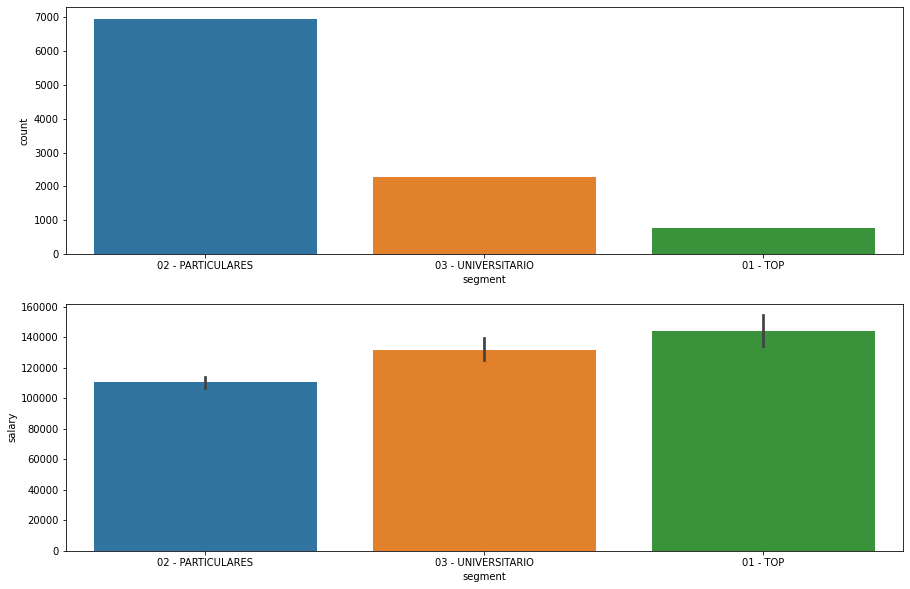

In [39]:
explore_cat_values(personalizacion, 'segment', 'salary')

Vemos una relación entre segment y salary (ingresos brutos de la unidad familiar) que podría tener sentido: 
Los 01- TOP con un salario más alto. 
02- PARTICULARES con un salario más bajo podría incluir desempleados, autónomos y trabajadores por cuenta ajena, por lo tanto, podría haber una mayor variabilidad de salarios y algunos bajos.
03- UNIVERSITARIOS con un salario intermedio podría incluir estudiantes universitarios que, aunque no estuviesen trabajando, consideran los ingresos de la unidad familiar y universitarios que podrían estar trabajando.

,Observaciones,Promedio,Mediana
segment,,,
02 - PARTICULARES,6942,39.936762,38
03 - UNIVERSITARIO,2281,27.402455,28
01 - TOP,777,51.419562,50


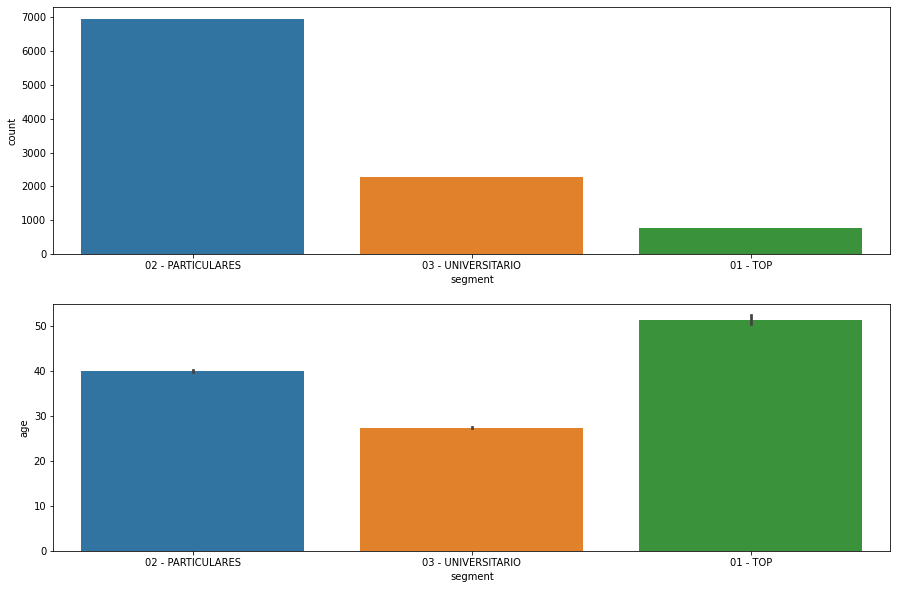

In [40]:
explore_cat_values(personalizacion, 'segment', 'age')

Al observar la relación entre segment y edad parece también tener sentido: Los top con un promedio de edad de 50 años son los mayores, los universitarios con una edad más baja y los particulares con una edad promedio comprendida entre estos dos segmentos. Por tanto, validamos el atributo segment y lo utilizaremos para rellenar los nulos de los salarios.

Los nulos de los salarios lo rellenaremos en función de la mediana del salario de cada segmento puesto que la mediana es menos sensible que el promedio a los valores extremos. 

In [41]:
personalizacion[personalizacion["segment"]=="01 - TOP"]['salary'].median()

117922.2

In [42]:
# para los del segment 01 -TOP
nan_filter = pd.Series(personalizacion['salary'][personalizacion['segment'] =='01 - TOP'].isnull())
nan_filter = nan_filter[nan_filter].index.values
nan_filter= pd.Series(nan_filter)
personalizacion.loc[nan_filter, 'salary'] = personalizacion.loc[nan_filter, 'salary'].fillna(personalizacion[personalizacion["segment"]=="01 - TOP"]['salary'].median())

In [43]:
personalizacion[personalizacion["segment"]=="02 - PARTICULARES"]['salary'].median()

85935.42

In [44]:
# Asignamos del salario para el segment 02 - PARTICULARES
nan_filter = pd.Series(personalizacion['salary'][personalizacion['segment'] =='02 - PARTICULARES'].isnull())
nan_filter = nan_filter[nan_filter].index.values
nan_filter= pd.Series(nan_filter)
personalizacion.loc[nan_filter, 'salary'] = personalizacion.loc[nan_filter, 'salary'].fillna(personalizacion[personalizacion["segment"]=="02 - PARTICULARES"]['salary'].median())

In [45]:
personalizacion[personalizacion["segment"]=="03 - UNIVERSITARIO"]['salary'].median()

99685.8

In [46]:
# para los del segment 03 - UNIVERSITARIO
nan_filter = pd.Series(personalizacion['salary'][personalizacion['segment'] =='03 - UNIVERSITARIO'].isnull())
nan_filter = nan_filter[nan_filter].index.values
nan_filter= pd.Series(nan_filter)
personalizacion.loc[nan_filter, 'salary'] = personalizacion.loc[nan_filter, 'salary'].fillna(personalizacion[personalizacion["segment"]=="03 - UNIVERSITARIO"]['salary'].median())

In [47]:
# Eliminamos segment del dataset, pues no la utilizaremos para el clustering
personalizacion.drop(['segment'], axis=1, inplace=True)

In [48]:
# comprobamos que ya no tenemos nulos
personalizacion.isnull().sum()

pk_cid        0
age           0
salary        0
idiomas       0
poblacion     0
media_prod    0
antiguedad    0
gender_V      0
dtype: int64

## Selección de los datos <a class="anchor" id="06"></a>
[Tabla de Contenido](#0)

In [49]:
personalizacion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pk_cid      10000 non-null  int64  
 1   age         10000 non-null  int8   
 2   salary      10000 non-null  float64
 3   idiomas     10000 non-null  int64  
 4   poblacion   10000 non-null  float64
 5   media_prod  10000 non-null  float64
 6   antiguedad  10000 non-null  float64
 7   gender_V    10000 non-null  uint8  
dtypes: float64(4), int64(2), int8(1), uint8(1)
memory usage: 824.4 KB


In [50]:
personalizacion.describe()

,pk_cid,age,salary,idiomas,poblacion,media_prod,antiguedad,gender_V
count,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,1.307221e+06,37.969900,1.076731e+05,0.233700,3.285536e+06,2.270379,20.185781,0.579600
std,1.996095e+05,11.677124,9.650735e+04,0.423205,2.652387e+06,1.020419,13.991285,0.493648
min,1.798000e+04,20.000000,1.265436e+04,0.000000,8.477700e+04,0.187500,1.018501,0.000000
25%,1.187204e+06,30.000000,8.108954e+04,0.000000,9.426650e+05,1.500000,7.655188,0.000000
50%,1.362840e+06,35.000000,8.593542e+04,0.000000,1.942389e+06,2.058824,16.624571,1.000000
75%,1.466152e+06,44.000000,1.140438e+05,0.000000,6.663394e+06,2.823529,30.916446,1.000000
max,1.547818e+06,99.000000,3.486835e+06,1.000000,1.525767e+07,7.764706,52.797799,1.000000


In [51]:
# asignamos 'pk_cid' como indice
personalizacion.set_index('pk_cid', inplace=True) 

# Modelling <a class="anchor" id="07"></a>
[Tabla de Contenido](#0)

Como explicamos anteriormente, usaremos el algoritmo de K-Means para segmentar los 10.000 clientes

In [52]:
# Eliminación de outliers porque pueden distorsionar los resultados del KMeans 
# (después de calcular los centroides, los incorporaremos para asignarlos a un cluster).

# Los atributos con mayores outliers son salary y age, por lo que consideraremos los que están hasta el quantile .90. 

# creamos los booleanos donde se cumplen que los clientes no son outliers en alguna de las columnas
criteria1 = personalizacion["salary"] < np.quantile(personalizacion["salary"], q = 0.90)
criteria2 = personalizacion["age"] < np.quantile(personalizacion["age"], q = 0.90)

# chained operations: juntamos los dos criterios. Por tanto nos quedaremos sólo con los clientes que no son outliers
# en salary ni en edad
criteria_final = criteria1 & criteria2
personalizacion_sin_out = personalizacion[criteria_final]

In [53]:
# hemos excluidos casi 2000 casos aproximadamente.
criteria_final.value_counts()

True     8068
False    1932
dtype: int64

In [54]:
personalizacion_sin_out = personalizacion[(personalizacion["salary"] < np.quantile(personalizacion["salary"], q = 0.90)) & (personalizacion["age"] < np.quantile(personalizacion["age"], q = 0.90))]

In [55]:
# El algoritmo requiere que escalemos los datos, por lo que utilizamos Standard Scaler
standard_scaler = StandardScaler()
scaled_df = standard_scaler.fit_transform(personalizacion_sin_out)
scaled_df = pd.DataFrame(scaled_df, index = personalizacion_sin_out.index, columns = personalizacion_sin_out.columns)

### Elbow curve <a class="anchor" id="08"></a>
[Tabla de Contenido](#0)

Para definir el número de clusters óptimo utilizaremos el Elbow Curve

In [56]:
CALCULATE_ELBOW = True

if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 10):

        print(f"Fitting pipe with {k} clusters")
        cluster_model = KMeans(n_clusters = k)
        cluster_model.fit(scaled_df)

        sse[k] = cluster_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Elbow curve took 0 minutes.


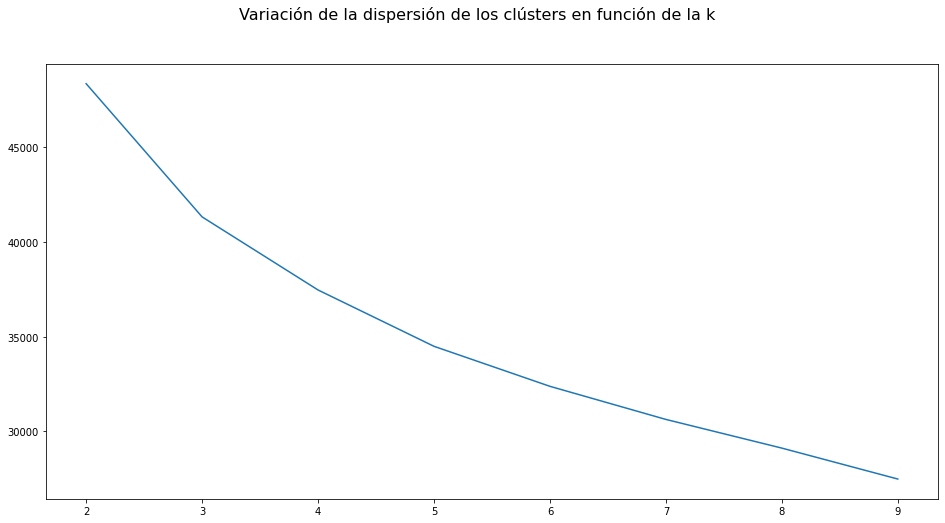

In [57]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

El mayor cambio de pendiente en la curva del codo se da entre el cluster 5.

In [58]:
cluster_model = KMeans(n_clusters = 5, random_state=42)
cluster_model.fit(scaled_df)

KMeans(n_clusters=5, random_state=42)

In [59]:
# se genera el dataframe escalado e incorporando los outliers.
scaled_df_with_outliers = standard_scaler.transform(personalizacion)

In [60]:
scaled_df_with_outliers = pd.DataFrame(scaled_df_with_outliers, 
                                       index = personalizacion.index, 
                                       columns = personalizacion.columns)

In [61]:
scaled_df_with_outliers.head()

,age,salary,idiomas,poblacion,media_prod,antiguedad,gender_V
pk_cid,,,,,,,
45483,3.000583,-0.372873,-0.556543,1.396968,-0.032798,1.711346,-1.171726
46823,4.900139,10.543963,-0.556543,1.396968,-1.093629,-0.006997,-1.171726
148406,1.480938,0.994761,-0.556543,-1.037327,-0.080683,-0.288308,0.853442
151516,2.367397,2.434066,-0.556543,1.396968,-0.268538,-0.004652,0.853442
177092,0.721116,-0.284703,1.796806,1.011423,-1.211499,1.490986,0.853442


In [62]:
# calculamos el cluster de cada cliente, a partir del dataframe escalado y con outliers
labels = cluster_model.predict(scaled_df_with_outliers)

In [63]:
personalizacion["cluster"] = labels

In [64]:
personalizacion.shape

(10000, 8)

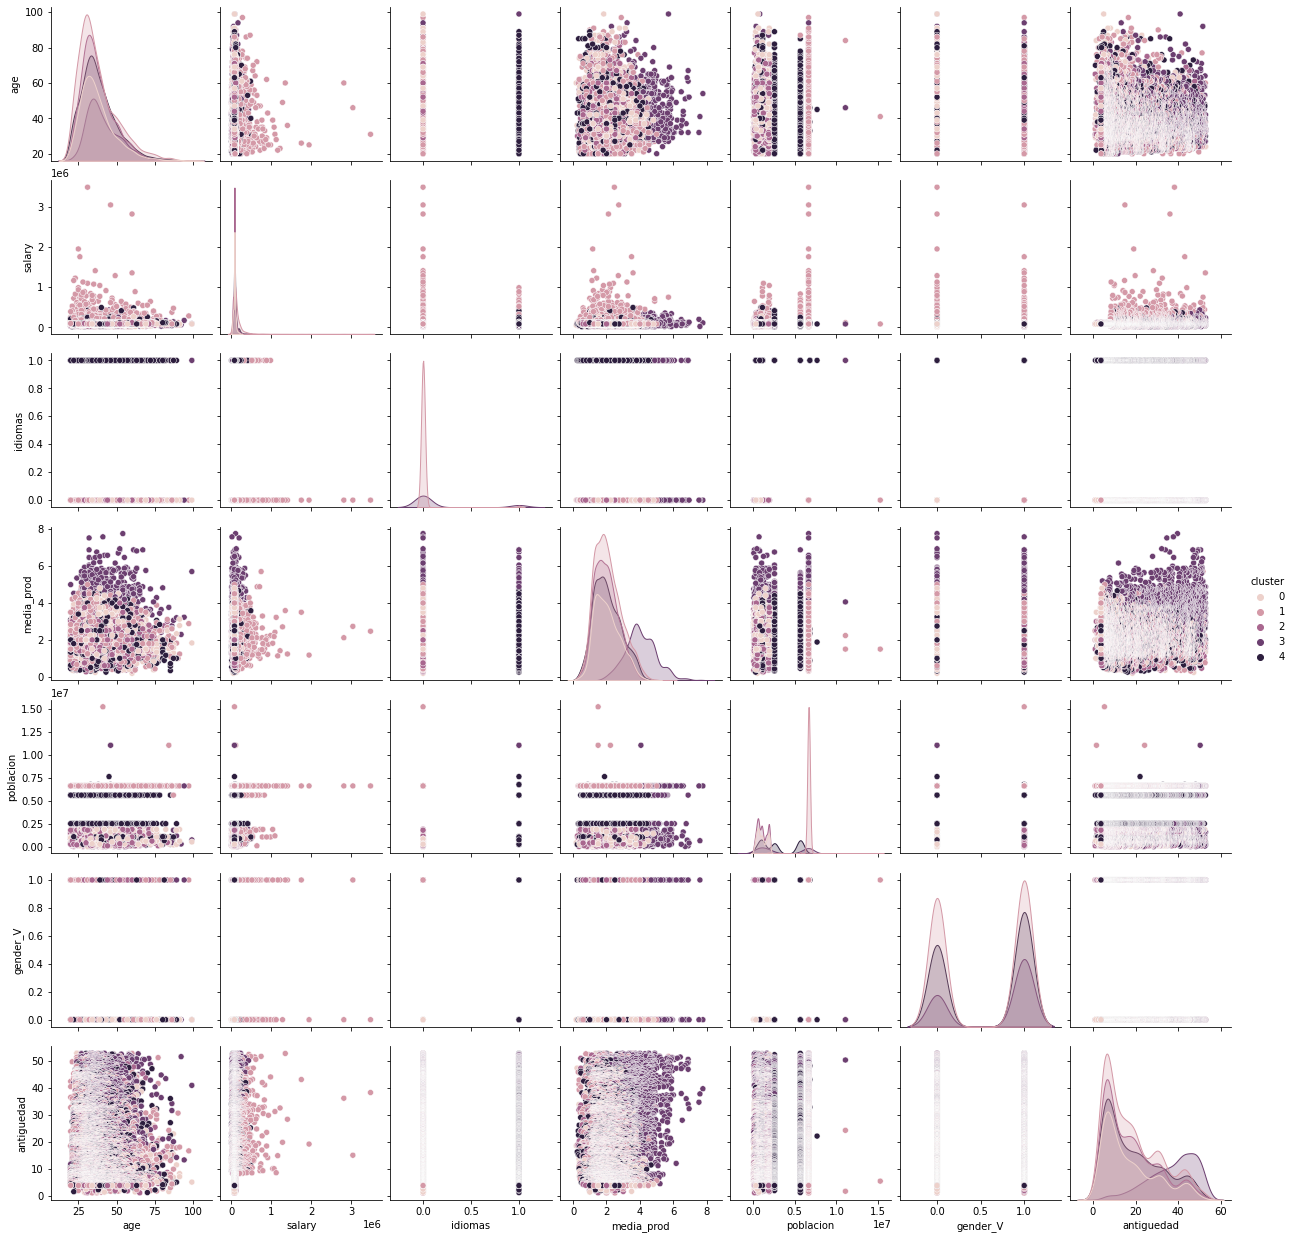

In [65]:
selected_columns = ['age', 'salary', 'idiomas', 'media_prod', 'poblacion', 'gender_V', 'antiguedad']

sns.pairplot(personalizacion, vars = selected_columns, hue = 'cluster');

In [66]:
# Vemos el tamaño de cada cluster
personalizacion.groupby("cluster").size()

cluster
0    1615
1    2850
2    2251
3    1153
4    2131
dtype: int64

In [67]:
personalizacion ['cluster'] =personalizacion ['cluster'] + 1

In [68]:
columnas = list(personalizacion.columns)
columnas.remove('cluster')

ficha_cluster= pd.pivot_table( personalizacion, index='cluster', values = columnas, aggfunc='mean')

ficha_cluster[columnas].style.background_gradient(cmap='coolwarm').set_precision(3)

,age,salary,idiomas,poblacion,media_prod,antiguedad,gender_V
cluster,,,,,,,
1,37.471,85957.415,0.000,1049914.034,2.044,17.140,0.000
2,37.316,146736.708,0.010,6561605.398,2.075,18.029,0.532
3,37.259,84509.736,0.000,1060231.604,1.979,17.457,1.000
4,41.513,102751.425,0.154,3342023.944,4.043,37.278,0.681
5,38.057,99017.525,1.000,2918458.278,2.052,19.013,0.584


### Descripción de los clusters <a class="anchor" id="09"></a> 
[Tabla de Contenido](#0)

· Cluster 1 y 3 - Mujeres y Hombres en ciudades pequeñas: En el cluster 1 hay solo mujeres y en el cluster 3 solo hombres, por tanto, la comunicación deberá dirigirse en el cluster 1 en femenino y en el cluster 3 en masculino. Para ambos clusters se recomienda que el tono de la comunicación sea amigable, puesto que son personas que viven en ciudades pequeñas y que, normalmente, las relaciones con los clientes suelen ser más cercanas y menos formales. 

· Cluster 2 - Urbanitas VIP: Clientes que viven en grandes ciudades con un alto salario. Se recomienda una comunicación formal y profesional, en castellano. En relación con el género, la comunicación deberá ser neutra, pues la componen tanto hombres como mujeres.

· Cluster 4 - Clientes leales y satisfechos: Son clientes que tienen varios de nuestros productos y han estado contratando nuestros servicios desde hace tiempo, por lo que se recomienda escribir unas líneas para agradecerles el tiempo que han estado con nosotros como clientes y la confianza en nuestra empresa y productos. La comunicación deberá ser en castellano, neutro en género y en tono semiformal, puesto que viven en ciudades de tamaño mediano y son personas adultas en general. 

· Cluster 5 - Bilingues: Este cluster está compuesto por clientes que hablan otro idioma como inglés, catalán o vasco, por lo que se recomienda hacer la comunicación en dos idiomas usando un tono semiformal y neutro en género.

# Conclusiones <a class="anchor" id="10"></a>
[Tabla de Contenido](#0)

En la tarea 4 de personalización de los correos que recibirán 10.000 clientes de la campaña de recomendación de los mejores productos, hemos utilizado el algoritmo de K-Means para agrupar a los clientes en función de ciertas características que nos ayudarán a dirigirnos a ellos de forma más efectiva.

Encontramos que lo óptimo sería agrupar a los clientes en 5 segmentos y diferenciar el escrito de la comunicación en función de la edad, salario, idioma, lugar de residencia del cliente, antiguedad como cliente, cantidad de productos contratados y sexo. 